# Building a classifier for detecting tuberculosis in chest X-rays
By Jonathan Feenstra (s1024219) and Justin Huberts (s1030368)

In this project we attempt to construct a binary Extreme Learning Machine (ELM) classifier to detect tuberculosis in lung X-rays. The U.S. National Library of Medicine has made two datasets of postero-anterior chest radiographs available which we will use to train and test our model: the Montgomery County Set and the Shenzen Set (Jaeger et al., 2014).

The datasets are available for download at [https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/](https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/)

## Sources
- Jaeger, S., Candemir, S., Antani, S., Wáng, Y., Lu, P., & Thoma, G. (2014). Two public chest X-ray datasets for computer-aided screening of pulmonary diseases. _Quantitative Imaging In Medicine And Surgery, 4_(6), 475-477.

## Some example images:

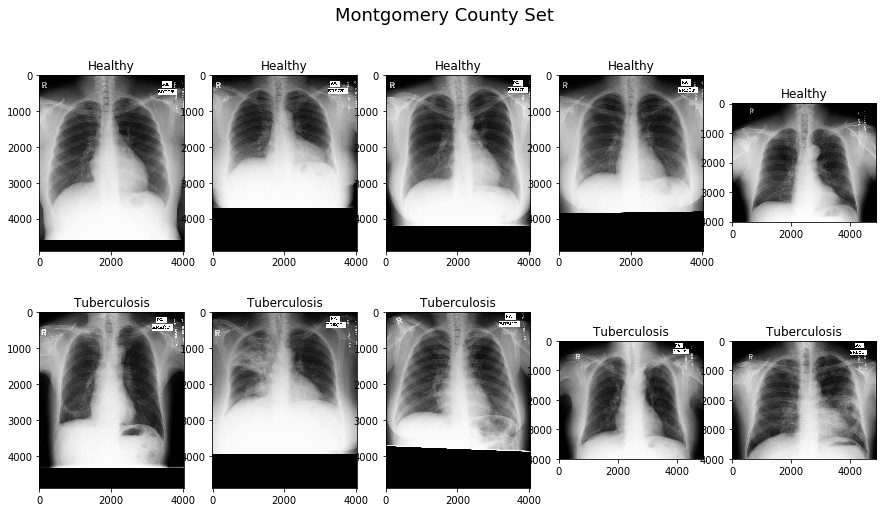

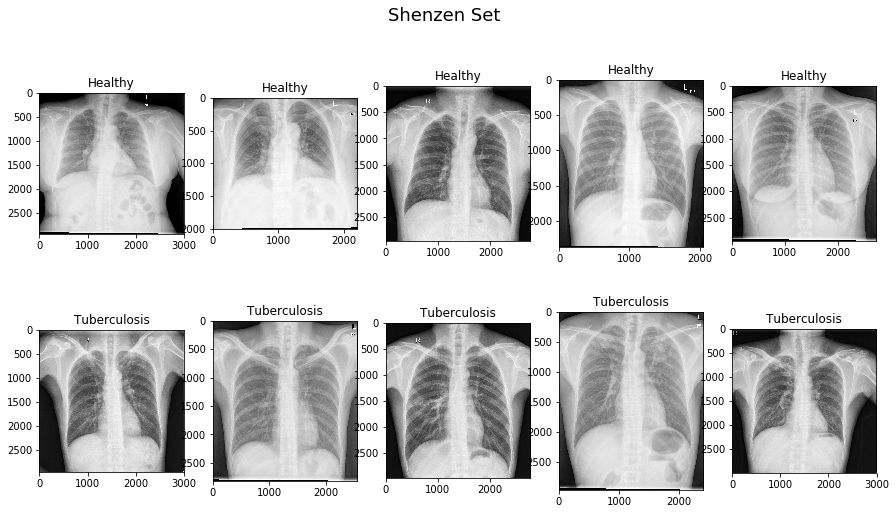

In [1]:
import glob
from random import sample

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

%matplotlib inline

mont_tb_neg = glob.glob('Data/MontgomerySet/CXR_png/*_0.png')
mont_tb_pos = glob.glob('Data/MontgomerySet/CXR_png/*_1.png')
shen_tb_neg = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*_0.png')
shen_tb_pos = glob.glob('Data/ChinaSet_AllFiles/CXR_png/*_1.png')

mont_set = mont_tb_neg + mont_tb_pos
shen_set = shen_tb_neg + shen_tb_pos

mont_tb_neg_sample = sample(mont_tb_neg, 5)
mont_tb_pos_sample = sample(mont_tb_pos, 5)
shen_tb_neg_sample = sample(shen_tb_neg, 5)
shen_tb_pos_sample = sample(shen_tb_pos, 5)

mont_fig = plt.figure(figsize=(15, 8))
mont_fig.suptitle('Montgomery County Set', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    img = mpimg.imread(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

shen_fig = plt.figure(figsize=(15, 8))
shen_fig.suptitle('Shenzen Set', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    img = mpimg.imread(filename)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
Since all Montgomery County images have a default size of either 4,020×4,892 or 4,892×4,020 pixels, while the actual X-ray size varies, some images contain empty space (black background). For the Shenzen Set the image sizes vary more. Furthermore, there is not always an obvious way to tell whether the X-ray is from a tuberculosis patient or a healthy person.

## Pre-processing
### Step 1: Trim the Montgomery set images to remove empty space
The following Python code was used to trim the images:
```
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
        

for filename in mont_set:
    trim(Image.open(filename)).save(filename.replace('CXR_png', 'Trimmed'))
```

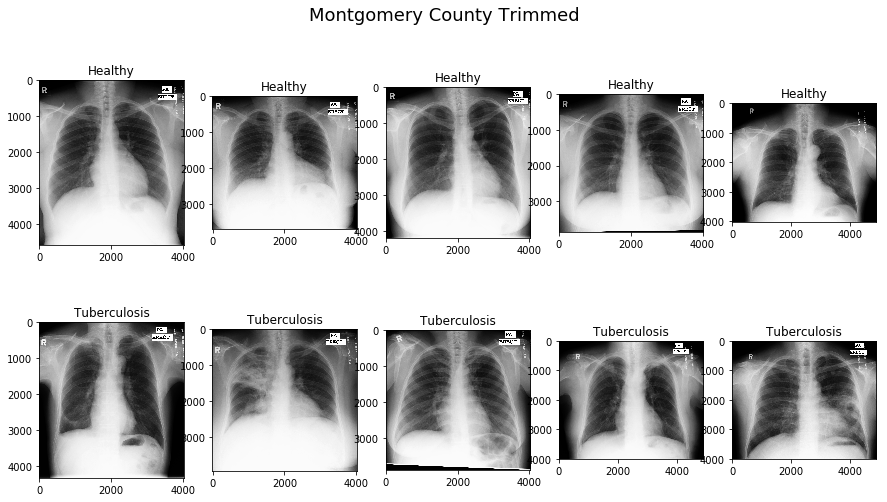

In [2]:
import numpy as np
from PIL import Image, ImageChops

mont_set = glob.glob('Data/MontgomerySet/Trimmed/*.png')

trim_fig = plt.figure(figsize=(15, 8))
trim_fig.suptitle('Montgomery County Trimmed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(Image.open(filename.replace('CXR_png', 'Trimmed'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
Now that the empty spaces of the images are trimmed away, the Montgomery County image sizes vary as well.

### Step 2: Compress all images to 1024×1024 pixels to prepare the images for bone shadow suppression
The following Python code was used to compress the images (using anti-aliasing):
```
for i, filename in enumerate(mont_set):
    Image.open(filename).resize((1024, 1024), Image.ANTIALIAS).save(
        filename.replace('Trimmed', 'Compressed'))

for i, filename in enumerate(shen_set):
    Image.open(filename).resize((1024, 1024), Image.ANTIALIAS).save(
        filename.replace('CXR_png', 'Compressed'))
```

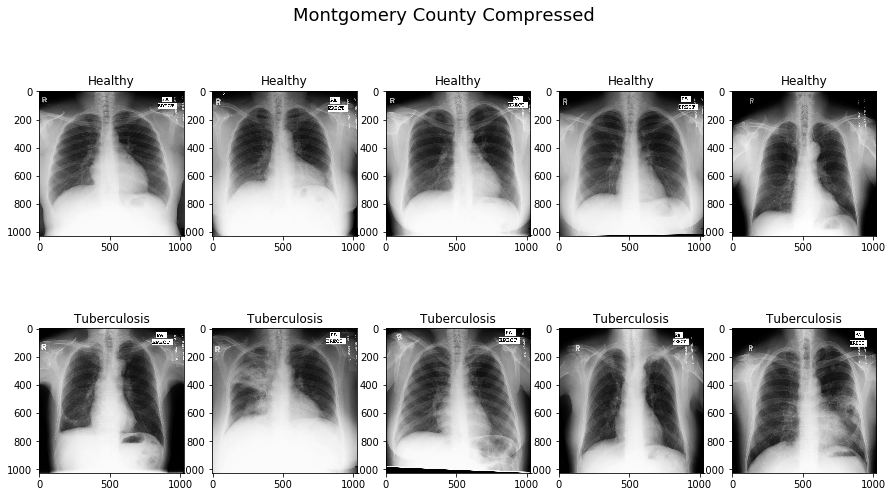

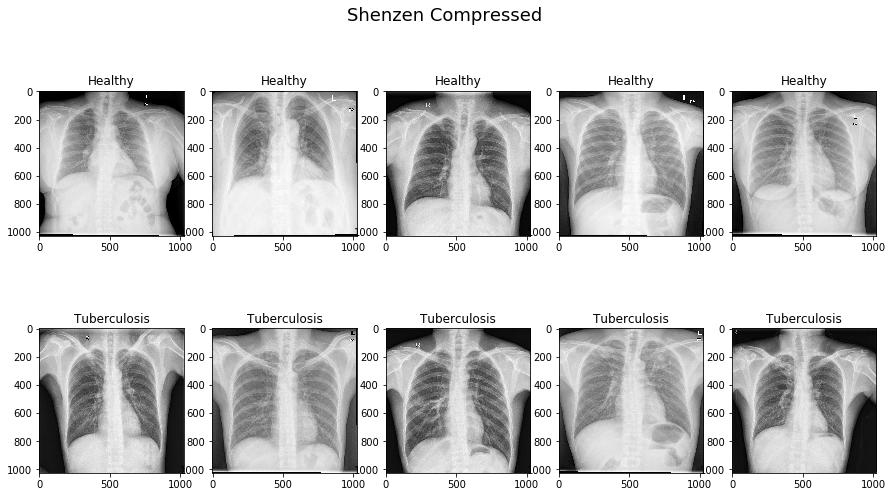

In [3]:
mont_fig = plt.figure(figsize=(15, 8))
mont_fig.suptitle('Montgomery County Compressed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(Image.open(filename.replace('CXR_png', 'Compressed'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

shen_fig = plt.figure(figsize=(15, 8))
shen_fig.suptitle('Shenzen Compressed', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(filename.replace('CXR_png',
                                        'Compressed')).convert('L')),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
As expected, all images are now 1024×1024 pixels, which has changed the horizontal/vertical scale a bit for all images that were not square-shaped. Hopefully this does not negatively affect the performance of the classifier.

### Step 3: Invert colors to prepare the images for bone shadow suppression
The following Python code was used to invert the colors of the images:
```
import os
import PIL.ImageOps

for filename in glob.glob('Data/MontgomerySet/Compressed/*.png') + glob.glob(
        'Data/ChinaSet_AllFiles/Compressed/*.png'):
    PIL.ImageOps.invert(
        Image.open(filename).convert('L')).save('Data/Inverted/' +
                                                os.path.basename(filename))
```

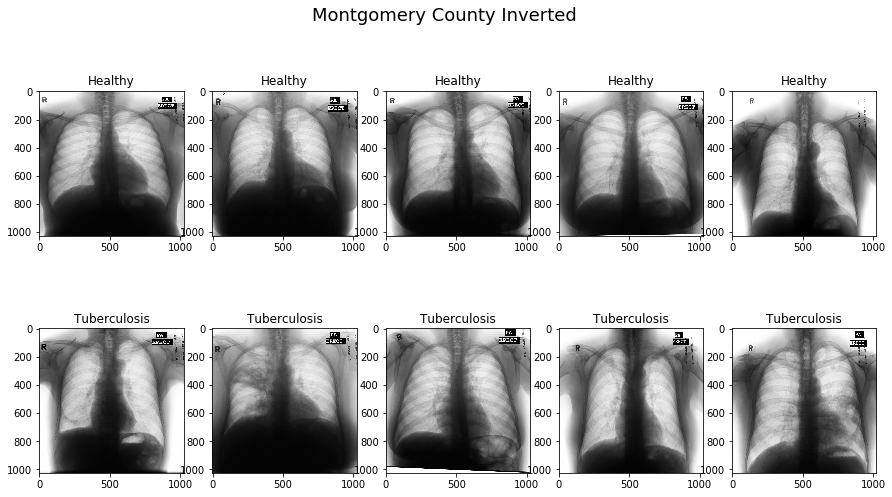

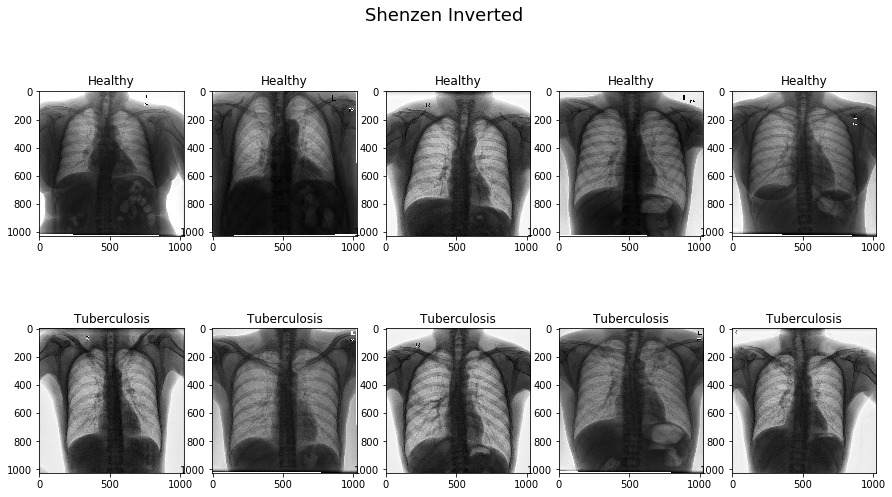

In [4]:
mont_fig = plt.figure(figsize=(15, 8))
mont_fig.suptitle('Montgomery County Inverted', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(filename.replace('MontgomerySet/CXR_png', 'Inverted'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

shen_fig = plt.figure(figsize=(15, 8))
shen_fig.suptitle('Shenzen Inverted', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(
                filename.replace('ChinaSet_AllFiles/CXR_png',
                                 'Inverted')).convert('L')),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
The colors were inverted properly, which has made the lungs brighter than the other parts of the chest. Remarkably, the lungs in the Montgomery County Set appear to look brighter than those in the Shenzen Set.

### Step 4: Apply bone shadow suppression
For this step we used the pretrained model from  [https://github.com/hmchuong/ML-BoneSuppression](https://github.com/hmchuong/ML-BoneSuppression) (version 1) to suppress the bone shadows of the inverted images using the following shell script (BASH):
```
#!/bin/bash
for filename in ./Data/Inverted/*
do
    python test.py --input \$filename --output "\${filename/Inverted/Suppressed}"
done
```
Note that executing this script requires some of the files from the [GitHub repository](https://github.com/hmchuong/ML-BoneSuppression).

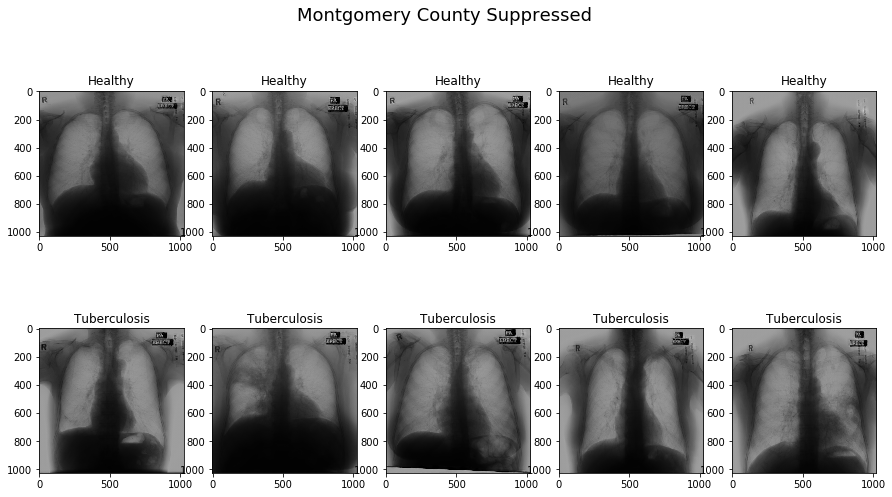

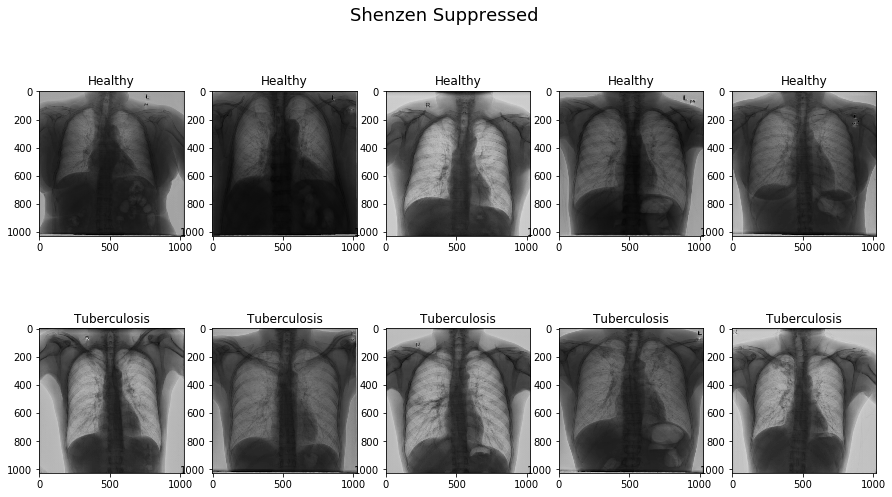

In [5]:
mont_fig = plt.figure(figsize=(15, 8))
mont_fig.suptitle('Montgomery County Suppressed', size=18)
for i, filename in enumerate(mont_tb_neg_sample + mont_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(
                filename.replace('MontgomerySet/CXR_png', 'Suppressed'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

shen_fig = plt.figure(figsize=(15, 8))
shen_fig.suptitle('Shenzen Suppressed', size=18)
for i, filename in enumerate(shen_tb_neg_sample + shen_tb_pos_sample):
    plt.subplot(2, 5, i + 1)
    plt.imshow(
        np.array(
            Image.open(
                filename.replace('ChinaSet_AllFiles/CXR_png', 'Suppressed'))),
        cmap='gray')
    if i <= 4:
        plt.title('Healthy')
    else:
        plt.title('Tuberculosis')

plt.show()

### Observations
The bone shadows have significantly been suppressed, especially for the Montgomery County Set.

## ELM classifier
A binary ELM classifier will be trained using the pre-processed images from the two datasets. It's performance will be evaluated by plotting an ROC-curve and a confusion matrix, as well as providing some relevant metrics.

Useful article: [https://ieeexplore.ieee.org/document/7140733](https://ieeexplore.ieee.org/document/7140733)

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


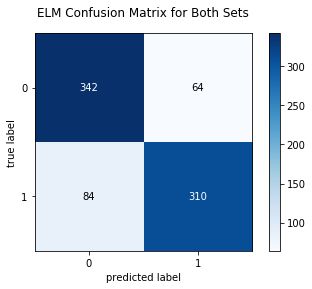

Accuracy: 0.815
Recall: 0.7868020304568528
F-measure: 0.8072916666666666
MSE: 0.13736000248796862
AUC: 0.8911004976119627


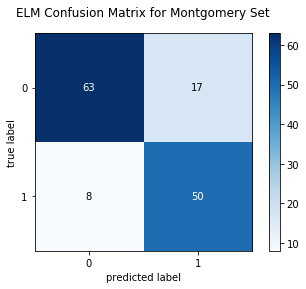

Accuracy: 0.8188405797101449
Recall: 0.8620689655172413
F-measure: 0.7999999999999999
MSE: 0.14396044593699428
AUC: 0.8765086206896552


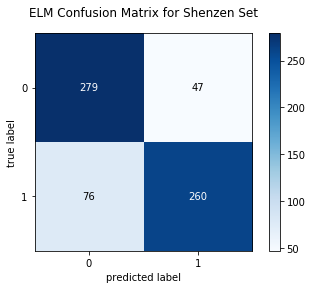

Accuracy: 0.8141993957703928
Recall: 0.7738095238095238
F-measure: 0.8087091757387248
MSE: 0.1359840792312223
AUC: 0.8927202015775635


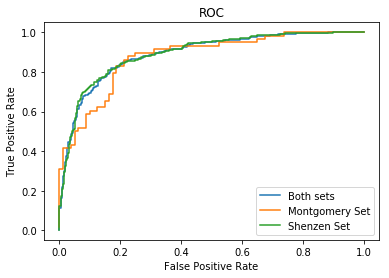

In [6]:
import os
import warnings

from hpelm import ELM
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import (accuracy_score, auc, confusion_matrix, f1_score,
                             recall_score, roc_curve)


def show_conf_matrix_and_metrics(y_true, y_pred, thresh, title):
    y_pred_classes = [0 if p < thresh else 1 for p in y_pred]
    plot_confusion_matrix(
        confusion_matrix(y_true, y_pred_classes), colorbar=True)
    plt.title(title)
    plt.show()
    print('Accuracy: {0}'.format(accuracy_score(y_true, y_pred_classes)))
    print('Recall: {0}'.format(recall_score(y_true, y_pred_classes)))
    print('F-measure: {0}'.format(f1_score(y_true, y_pred_classes)))
    print('MSE: {0}'.format(elm.error(y_true, y_pred)))


THRESH = 0.5

mont_images = []
shen_images = []
mont_labels = []
shen_labels = []

for filename in glob.glob('Data/Suppressed/*.png'):
    img = np.frombuffer(
        Image.open(filename).resize((512, 512), Image.ANTIALIAS).tobytes(),
        dtype=np.uint8)
    if os.path.basename(filename)[0] == 'C':
        shen_images.append(img)
        shen_labels.append(int(os.path.splitext(filename)[0][-1]))
    elif os.path.basename(filename)[0] == 'M':
        mont_images.append(img)
        mont_labels.append(int(os.path.splitext(filename)[0][-1]))

X_both = np.array(mont_images + shen_images)
y_both = np.array(mont_labels + shen_labels, dtype=np.int64)

X_mont = np.array(mont_images)
y_mont = np.array(mont_labels, dtype=np.int64)

X_shen = np.array(shen_images)
y_shen = np.array(shen_labels, dtype=np.int64)

elm = ELM(262144, 1)
elm.add_neurons(150, 'sigm')
elm.add_neurons(2, 'lin')

# TODO: Split train/test data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    elm.train(X_both, y_both)
    y_pred_both = elm.predict(X_both)

fpr_both, tpr_both, threshold_both = roc_curve(y_both, y_pred_both)

show_conf_matrix_and_metrics(y_both, y_pred_both, THRESH,
                             'ELM Confusion Matrix for Both Sets')
print('AUC: {0}'.format(auc(fpr_both, tpr_both)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_pred_mont = elm.predict(X_mont)

fpr_mont, tpr_mont, threshold_mont = roc_curve(y_mont, y_pred_mont)

show_conf_matrix_and_metrics(y_mont, y_pred_mont, THRESH,
                             'ELM Confusion Matrix for Montgomery Set')
print('AUC: {0}'.format(auc(fpr_mont, tpr_mont)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_pred_shen = elm.predict(X_shen)

fpr_shen, tpr_shen, threshold_shen = roc_curve(y_shen, y_pred_shen)

show_conf_matrix_and_metrics(y_shen, y_pred_shen, THRESH,
                             'ELM Confusion Matrix for Shenzen Set')
print('AUC: {0}'.format(auc(fpr_shen, tpr_shen)))

# ROC curve
plt.plot(fpr_both, tpr_both, label='Both sets')
plt.plot(fpr_mont, tpr_mont, label='Montgomery Set')
plt.plot(fpr_shen, tpr_shen, label='Shenzen Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC')

plt.show()
# TODO: k-fold cross validation (k=10)

### Without bone shadow suppression

Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons


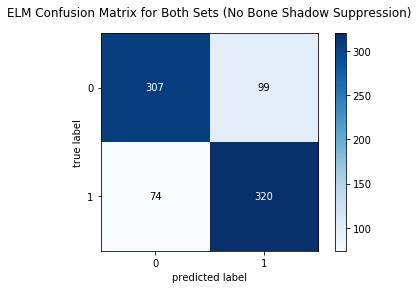

Accuracy: 0.78375
Recall: 0.8121827411167513
F-measure: 0.7872078720787207
MSE: 0.14963429076598334
AUC: 0.8713835613012928


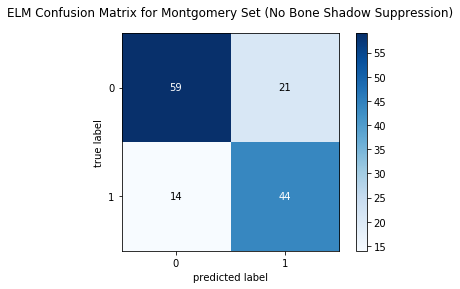

Accuracy: 0.7463768115942029
Recall: 0.7586206896551724
F-measure: 0.7154471544715447
MSE: 0.16665624989924754
AUC: 0.8396551724137931


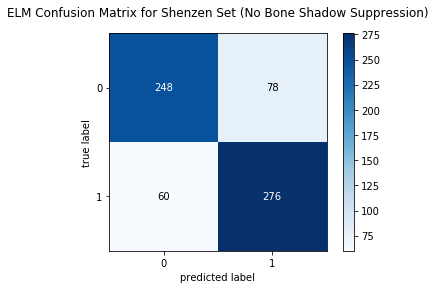

Accuracy: 0.7915407854984894
Recall: 0.8214285714285714
F-measure: 0.8
MSE: 0.14608590653578624
AUC: 0.878058355243938


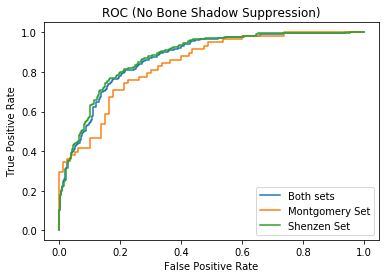

In [7]:
mont_images = []
shen_images = []
mont_labels = []
shen_labels = []

for filename in glob.glob('Data/Inverted/*.png'):
    img = np.frombuffer(
        Image.open(filename).resize((512, 512), Image.ANTIALIAS).tobytes(),
        dtype=np.uint8)
    if os.path.basename(filename)[0] == 'C':
        shen_images.append(img)
        shen_labels.append(int(os.path.splitext(filename)[0][-1]))
    elif os.path.basename(filename)[0] == 'M':
        mont_images.append(img)
        mont_labels.append(int(os.path.splitext(filename)[0][-1]))

X_both = np.array(mont_images + shen_images)
y_both = np.array(mont_labels + shen_labels, dtype=np.int64)

X_mont = np.array(mont_images)
y_mont = np.array(mont_labels, dtype=np.int64)

X_shen = np.array(shen_images)
y_shen = np.array(shen_labels, dtype=np.int64)

elm = ELM(262144, 1)

elm.add_neurons(150, 'sigm')
elm.add_neurons(2, 'lin')

# TODO: Split train/test data
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    elm.train(X_both, y_both)
    y_pred_both = elm.predict(X_both)

fpr_both, tpr_both, threshold_both = roc_curve(y_both, y_pred_both)

show_conf_matrix_and_metrics(
    y_both, y_pred_both, THRESH,
    'ELM Confusion Matrix for Both Sets (No Bone Shadow Suppression)')
print('AUC: {0}'.format(auc(fpr_both, tpr_both)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_pred_mont = elm.predict(X_mont)

fpr_mont, tpr_mont, threshold_mont = roc_curve(y_mont, y_pred_mont)

show_conf_matrix_and_metrics(
    y_mont, y_pred_mont, THRESH,
    'ELM Confusion Matrix for Montgomery Set (No Bone Shadow Suppression)')
print('AUC: {0}'.format(auc(fpr_mont, tpr_mont)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    y_pred_shen = elm.predict(X_shen)

fpr_shen, tpr_shen, threshold_shen = roc_curve(y_shen, y_pred_shen)

show_conf_matrix_and_metrics(
    y_shen, y_pred_shen, THRESH,
    'ELM Confusion Matrix for Shenzen Set (No Bone Shadow Suppression)')
print('AUC: {0}'.format(auc(fpr_shen, tpr_shen)))

# ROC curve
plt.plot(fpr_both, tpr_both, label='Both sets')
plt.plot(fpr_mont, tpr_mont, label='Montgomery Set')
plt.plot(fpr_shen, tpr_shen, label='Shenzen Set')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.title('ROC (No Bone Shadow Suppression)')

plt.show()
# TODO: k-fold cross validation (k=10)

### Observations
The ELM seems to perform reasonably well for this classification task, with an accuracy, recall and F-measure around 80% when tested on both sets together. When only testing the Montgomery Set, the scores are a little bit lower (possibly because the ELM was trained on fewer images of this set). Suprisingly, the ELM seems to perform slightly better without bone shadow suppression.

## Conclusion
Even though an ELM can be trained faster than a convolutional neural network, it's classification performance on X-ray images is still inferior.